### Both Max and Min Price

Optimized MLR for Max Performance:
MAE: 139.2978, MSE: 36435.6114, RMSE: 190.8811, MAPE: 0.2235%

Optimized MLR for Min Performance:
MAE: 1045.1303, MSE: 1853597.5845, RMSE: 1361.4689, MAPE: 2.1875%



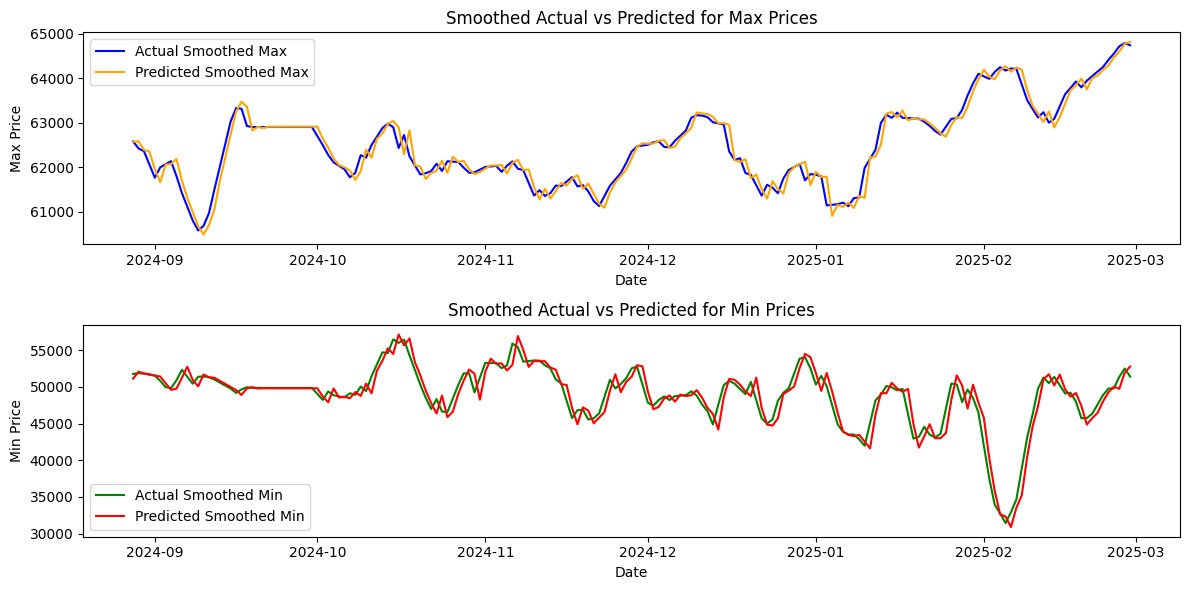

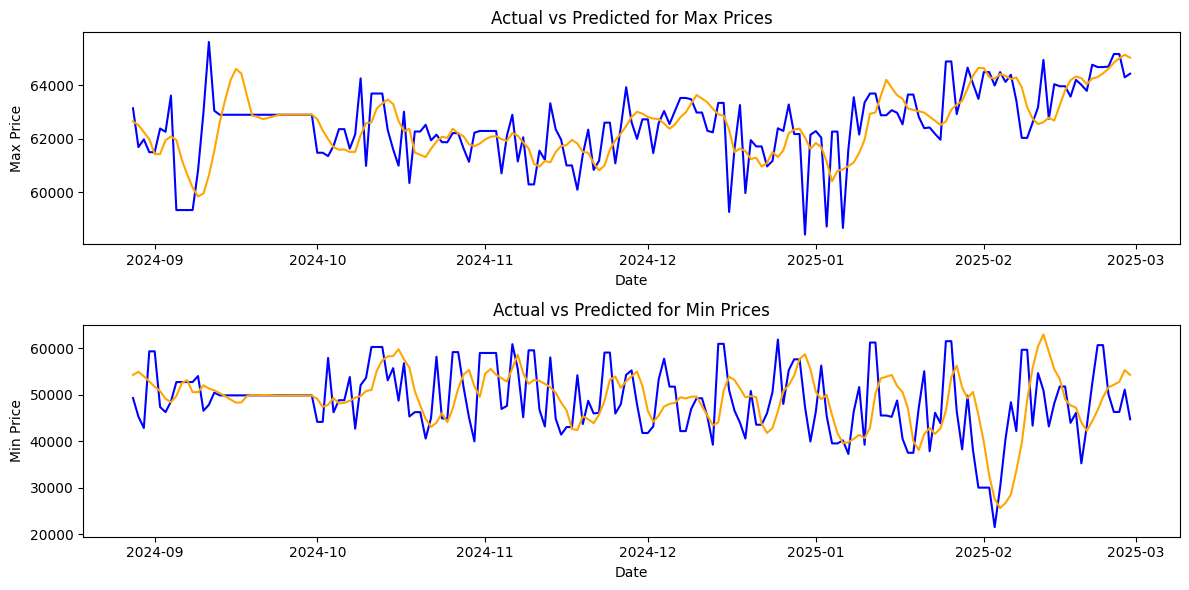

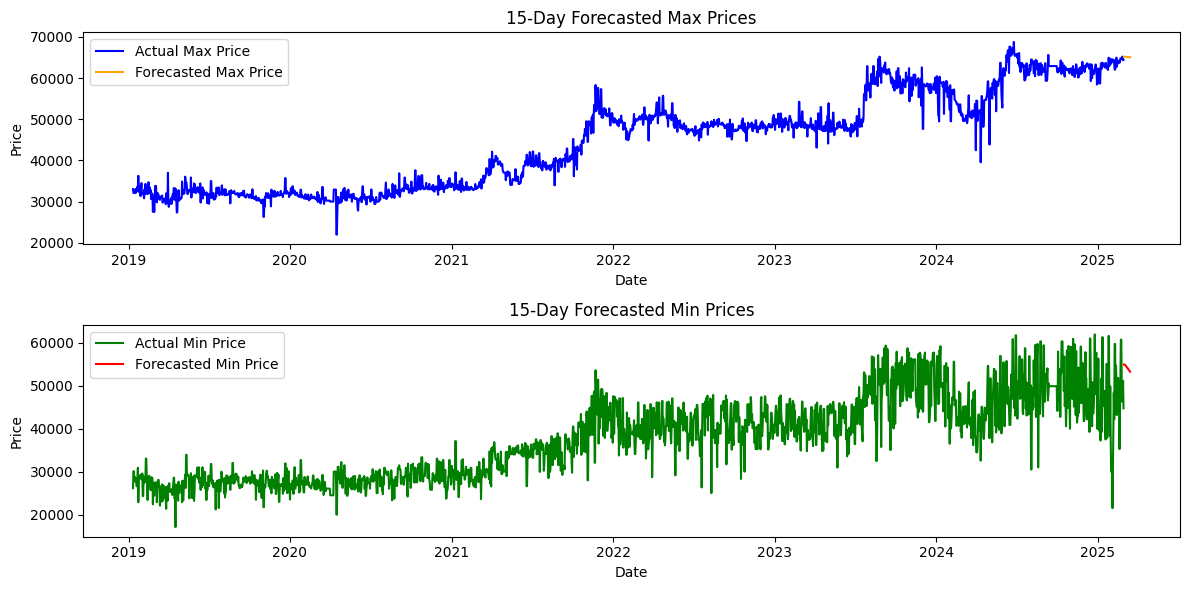

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Read Source file
file_path = "PepperData2019-24-latest-Till-Feb2025.xlsx"
df_data = pd.read_excel(file_path, sheet_name="Sheet1")
df_data["Date"] = pd.to_datetime(df_data["Date"]).dt.strftime("%m-%d-%y")

# Filter for specific districts
df_copy = df_data[df_data['District'].isin(['Uttara Kannada', 'Dakshina Kannada', 'Udupi'])]

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for Max and Min prices
filtered_df = remove_outliers(df_copy, 'Max')
#filtered_df = remove_outliers(filtered_df, 'Min')  # Also remove outliers for Min price
filtered_df.reset_index(drop=True, inplace=True)

# Filling missing values
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
grouped_df = filtered_df.groupby('Date').agg(
    Max=('Max', 'mean'),
    Min=('Min', 'mean'),
    Modal=('Modal', 'mean'),
    Sum_Arrival=('Arrivals', 'mean')
).reset_index()

grouped_df.set_index('Date', inplace=True)
date_range = pd.date_range(start=grouped_df.index.min(), end=grouped_df.index.max())
grouped_df = grouped_df.reindex(date_range, fill_value=np.nan)
grouped_df.fillna(method='ffill', inplace=True)
grouped_df.reset_index(inplace=True)
grouped_df.rename(columns={'index': 'Date'}, inplace=True)

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define performance evaluation function
def evaluate_performance(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%\n")
    return mae, mse, rmse, mape

# Load dataset
df = grouped_df.copy()

# Ensure 'Date' is in datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Filter dataset to include data up to the end date
end_date = df.index.max()
test_start_date = end_date - pd.DateOffset(months=6)
df = df[df.index <= end_date]

# Apply rolling mean smoothing for Max and Min prices
df['Smoothed_Max'] = df['Max'].rolling(window=7, min_periods=1).mean()
df['Smoothed_Min'] = df['Min'].rolling(window=7, min_periods=1).mean()

# Compute past 7-day weight distribution for both Max and Min
for i in range(7):
    df[f'Weight_Day_Max{i+1}'] = df['Max'].shift(i) / df['Smoothed_Max'].shift(i)
    df[f'Weight_Day_Min{i+1}'] = df['Min'].shift(i) / df['Smoothed_Min'].shift(i)

df['Weight_Avg_Max'] = df[[f'Weight_Day_Max{i+1}' for i in range(7)]].mean(axis=1)
df['Weight_Avg_Min'] = df[[f'Weight_Day_Min{i+1}' for i in range(7)]].mean(axis=1)

df.dropna(inplace=True)

# Feature Engineering for Max and Min prices
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

# Create lag features for Max and Min prices
for lag in range(1, 5):
    df[f'Lag_Max{lag}'] = df['Smoothed_Max'].shift(lag)
    df[f'Lag_Min{lag}'] = df['Smoothed_Min'].shift(lag)

df.dropna(inplace=True)

# Split train-test based on last 6 months
df_train = df[df.index < test_start_date]
df_test = df[df.index >= test_start_date]

# Define features for Max and Min prices
features_max = ['DayOfWeek', 'Month', 'Lag_Max1', 'Lag_Max2', 'Lag_Max3', 'Lag_Max4']
features_min = ['DayOfWeek', 'Month', 'Lag_Min1', 'Lag_Min2', 'Lag_Min3', 'Lag_Min4']

# Define target variables for Max and Min prices
target_max = 'Smoothed_Max'
target_min = 'Smoothed_Min'

# Split data for Max price prediction
X_train_max, y_train_max = df_train[features_max], df_train[target_max]
X_test_max, y_test_max = df_test[features_max], df_test[target_max]

# Split data for Min price prediction
X_train_min, y_train_min = df_train[features_min], df_train[target_min]
X_test_min, y_test_min = df_test[features_min], df_test[target_min]

# Train Model for Max price prediction
mlr_max = LinearRegression()
mlr_max.fit(X_train_max, y_train_max)

# Train Model for Min price prediction
mlr_min = LinearRegression()
mlr_min.fit(X_train_min, y_train_min)

# Predictions for Max and Min prices
df_test['Smoothed_Predicted_Max'] = mlr_max.predict(X_test_max)
df_test['Smoothed_Predicted_Min'] = mlr_min.predict(X_test_min)

# Convert smoothed predicted values to actual price predictions
df_test['Weighted_Predicted_Max'] = df_test['Smoothed_Predicted_Max'] * df_test['Weight_Avg_Max']
df_test['Weighted_Predicted_Min'] = df_test['Smoothed_Predicted_Min'] * df_test['Weight_Avg_Min']

# Evaluate Performance for both Max and Min prices
evaluate_performance(df_test['Smoothed_Max'], df_test['Smoothed_Predicted_Max'], "Optimized MLR for Max")
evaluate_performance(df_test['Smoothed_Min'], df_test['Smoothed_Predicted_Min'], "Optimized MLR for Min")

# Forecasting for next 15 days for both Max and Min prices
forecast_start = end_date + pd.DateOffset(days=1)
forecast_end = forecast_start + pd.DateOffset(days=14)

forecast_dates = pd.date_range(start=forecast_start, end=forecast_end)
forecast_values_max = []
forecast_values_min = []

last_values_max = df.iloc[-1][['Lag_Max1', 'Lag_Max2', 'Lag_Max3', 'Lag_Max4']].values
last_values_min = df.iloc[-1][['Lag_Min1', 'Lag_Min2', 'Lag_Min3', 'Lag_Min4']].values

for next_date in forecast_dates:
    next_features_max = np.array([next_date.dayofweek, next_date.month] + list(last_values_max)).reshape(1, -1)
    next_pred_max = mlr_max.predict(next_features_max)[0]
    
    next_features_min = np.array([next_date.dayofweek, next_date.month] + list(last_values_min)).reshape(1, -1)
    next_pred_min = mlr_min.predict(next_features_min)[0]
    
    last_values_max = np.roll(last_values_max, 1)
    last_values_max[0] = next_pred_max
    
    last_values_min = np.roll(last_values_min, 1)
    last_values_min[0] = next_pred_min
    
    forecast_values_max.append(next_pred_max)
    forecast_values_min.append(next_pred_min)

forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_Smoothed_Max': forecast_values_max, 'Forecasted_Smoothed_Min': forecast_values_min})
forecast_df.set_index('Date', inplace=True)

# Convert smoothed forecast to actual daily prices using recent weight distribution
latest_weight_avg_max = df['Weight_Avg_Max'].iloc[-7:].values
latest_weight_avg_min = df['Weight_Avg_Min'].iloc[-7:].values

forecast_df['Actual_Forecasted_Max'] = forecast_df['Forecasted_Smoothed_Max'] * latest_weight_avg_max.mean()
forecast_df['Actual_Forecasted_Min'] = forecast_df['Forecasted_Smoothed_Min'] * latest_weight_avg_min.mean()

df_test['Abs_Diff_Max'] = np.abs(df_test['Smoothed_Max'] - df_test['Smoothed_Predicted_Max'])
df_test['Pct_Error_Max'] = (df_test['Abs_Diff_Max'] / df_test['Smoothed_Max']) * 100

df_test['Abs_Diff_Min'] = np.abs(df_test['Smoothed_Min'] - df_test['Smoothed_Predicted_Min'])
df_test['Pct_Error_Min'] = (df_test['Abs_Diff_Min'] / df_test['Smoothed_Min']) * 100

df_test['Abs_Diff_Actual_Max'] = np.abs(df_test['Max'] - df_test['Weighted_Predicted_Max'])
df_test['Pct_Error_Actual_Max'] = (df_test['Abs_Diff_Actual_Max'] / df_test['Max']) * 100

# Absolute Difference and Percentage Error for actual Min prices
df_test['Abs_Diff_Actual_Min'] = np.abs(df_test['Min'] - df_test['Weighted_Predicted_Min'])
df_test['Pct_Error_Actual_Min'] = (df_test['Abs_Diff_Actual_Min'] / df_test['Min']) * 100

# Create output DataFrame for test data
#test_results = df_test[['Smoothed_Max','Smoothed_Predicted_Max','Max','Weighted_Predicted_Max','Abs_Diff_Actual_Max','Pct_Error_Actual_Max','Smoothed_Min','Smoothed_Predicted_Min', 'Min','Weighted_Predicted_Min','Abs_Diff_Actual_Min','Pct_Error_Actual_Min']].copy()
test_results = df_test[['Max','Weighted_Predicted_Max','Abs_Diff_Actual_Max','Pct_Error_Actual_Max','Min','Weighted_Predicted_Min','Abs_Diff_Actual_Min','Pct_Error_Actual_Min']].copy()
test_results.reset_index(inplace=True)
test_results.rename(columns={
   # 'Smoothed_Max': 'Actual_Smoothed_Max',
   # 'Smoothed_Predicted_Max': 'Predicted_Smoothed_Max',
    'Max': 'Actual_Max_Price',
    'Weighted_Predicted_Max': 'Predicted_Actual_Max',
    'Abs_Diff_Actual_Max': 'Abs_Diff_Actual_Max',
    'Pct_Error_Actual_Max': 'Pct_Error_Actual_Max %',
    #'Smoothed_Min': 'Actual_Smoothed_Min',
    #'Smoothed_Predicted_Min': 'Predicted_Smoothed_Min',
    'Min': 'Actual_Min_Price',
    'Weighted_Predicted_Min': 'Predicted_Actual_Min',
    'Abs_Diff_Actual_Min': 'Abs_Diff_Actual_Min',
    'Pct_Error_Actual_Min': 'Pct_Error_Actual_Min %',
}, inplace=True)

# Prepare forecast DataFrame
forecast_output = forecast_df[['Actual_Forecasted_Max','Actual_Forecasted_Min']].copy()
forecast_output.reset_index(inplace=True)
forecast_output.rename(columns={
    #'Forecasted_Smoothed_Max': 'Forecasted_Smoothed_Max',
    'Actual_Forecasted_Max': 'Forecasted_Actual_Max',
    #'Forecasted_Smoothed_Min': 'Forecasted_Smoothed_Min',
    'Actual_Forecasted_Min': 'Forecasted_Actual_Min'
}, inplace=True)

# Save to Excel
with pd.ExcelWriter("Price_Forecast_Results_Max_Min.xlsx") as writer:
    test_results.to_excel(writer, sheet_name="Test_Results", index=False)
    forecast_output.to_excel(writer, sheet_name="15_Day_Forecast", index=False)

# Smoothed Actual vs Predicted Plot for Max and Min
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_test.index, df_test['Smoothed_Max'], label='Actual Smoothed Max', color='blue')
plt.plot(df_test.index, df_test['Smoothed_Predicted_Max'], label='Predicted Smoothed Max', color='orange')
plt.title('Smoothed Actual vs Predicted for Max Prices')
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_test.index, df_test['Smoothed_Min'], label='Actual Smoothed Min', color='green')
plt.plot(df_test.index, df_test['Smoothed_Predicted_Min'], label='Predicted Smoothed Min', color='red')
plt.title('Smoothed Actual vs Predicted for Min Prices')
plt.xlabel('Date')
plt.ylabel('Min Price')
plt.legend()

plt.tight_layout()
plt.show()

# Actual vs Predicted Plot for Max and Min
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_test.index,df_test['Max'], label='Actual Max', color='blue')
plt.plot(df_test.index, df_test['Weighted_Predicted_Max'], label='Predicted Actual Max', color='orange')
plt.title('Actual vs Predicted for Max Prices')
plt.xlabel('Date')
plt.ylabel('Max Price')

plt.subplot(2, 1, 2)
plt.plot(df_test.index,df_test['Min'], label='Actual Min', color='blue')
plt.plot(df_test.index, df_test['Weighted_Predicted_Min'], label='Predicted Actual Min', color='orange')
plt.title('Actual vs Predicted for Min Prices')
plt.xlabel('Date')
plt.ylabel('Min Price')

plt.tight_layout()
plt.show()

# 15-Day Forecasted Plot for Max and Min with all 6 years data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Max'], label='Actual Max Price', color='blue')
plt.plot(forecast_df.index, forecast_df['Actual_Forecasted_Max'], label='Forecasted Max Price', color='orange')
plt.title('15-Day Forecasted Max Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df.index, df['Min'], label='Actual Min Price', color='green')
plt.plot(forecast_df.index, forecast_df['Actual_Forecasted_Min'], label='Forecasted Min Price', color='red')
plt.title('15-Day Forecasted Min Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()
